In [6]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
#from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

### Custom dataset

In [7]:
# if your dataset is in COCO format, this cell can be replaced by the following three lines:
# from detectron2.data.datasets import register_coco_instances
# register_coco_instances("my_dataset_train", {}, "json_annotation_train.json", "path/to/image/dir")
# register_coco_instances("my_dataset_val", {}, "json_annotation_val.json", "path/to/image/dir")

from detectron2.structures import BoxMode
import glob
from astropy.io import fits

def get_astro_dicts(img_dir):
    
    
    # It's weird to call this img_dir
    #set_dirs = glob.glob('%s/set_*' % img_dir)
    set_dirs = ['%s/set_%d' % (img_dir, i) for i in range(10)]
    
    dataset_dicts = []
    
    # Loop through each set
    for idx, set_dir in enumerate(set_dirs):
        record = {}
        
        mask_dir = os.path.join(img_dir, set_dir, "masks.fits")
        filename = os.path.join(img_dir, set_dir, "img")
        
        # Open each FITS image
        with fits.open(mask_dir, memmap=False, lazy_load_hdus=False) as hdul:
            sources = len(hdul)
            height, width = hdul[0].data.shape
            data = [hdu.data/np.max(hdu.data) for hdu in hdul]
            category_ids = [hdu.header["CLASS_ID"] for hdu in hdul]
            
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
        objs = []
        
        # Mask value thresholds per category_id
        thresh = [0.005 if i == 1 else 0.08 for i in category_ids]
        
        # Generate segmentation masks
        for i in range(sources):
            image = data[i]
            mask = np.zeros([height, width], dtype=np.uint8)
            # Create mask from threshold
            mask[:,:][image > thresh[i]] = 1
            # Smooth mask
            mask[:,:] = cv2.GaussianBlur(mask[:,:], (9,9), 2)
            
            # https://github.com/facebookresearch/Detectron/issues/100
            mask_new, contours, hierarchy = cv2.findContours((mask).astype(np.uint8), cv2.RETR_TREE,
                                                        cv2.CHAIN_APPROX_SIMPLE)
            segmentation = []
            for contour in contours:
                x,y,w,h = cv2.boundingRect(contour)
                contour = contour.flatten().tolist()
                # segmentation.append(contour)
                if len(contour) > 4:
                    segmentation.append(contour)
            # No valid countors
            if len(segmentation) == 0:
                continue
            
            # Add to dict
            obj = {
                "bbox": [x, y, w, h],
                "area": w*h,
                "bbox_mode": BoxMode.XYWH_ABS,
                "segmentation": segmentation,
                "category_id": category_ids[i] - 1,
            }
            objs.append(obj)
            
        record["annotations"] = objs
        dataset_dicts.append(record)
         
    return dataset_dicts

# Register dataset
for d in ["train", "val"]:
    DatasetCatalog.register("astro_" + d, lambda: get_astro_dicts("/home/colinjb2/astro_rcnn/trainingset"))
    MetadataCatalog.get("astro_" + d).set(thing_classes=["star", "galaxy"])
astro_metadata = MetadataCatalog.get("astro_train")

In [8]:
from detectron2.data import build_detection_train_loader

def read_image(filename, normalize='lupton', stretch=5, Q=10, m=0, ceil_percentile=99.995, dtype=np.uint8):
    # Read image
    # TODO: Combine these files into one img_0, mask_0 ... in simulate.py
    g = fits.getdata(os.path.join(filename+'_g.fits.gz'), memmap=False)
    r = fits.getdata(os.path.join(filename+'_r.fits.gz'), memmap=False)
    z = fits.getdata(os.path.join(filename+'_z.fits.gz'), memmap=False)
    
    # Contrast scaling / normalization
    I = (z + r + g)/3.0
    
    length, width = g.shape
    image = np.empty([length, width, 3], dtype=dtype)
    
    # Options for contrast scaling
    if normalize.lower() == 'lupton':
        z = z*np.arcsinh(stretch*Q*(I - m))/(Q*I)
        r = r*np.arcsinh(stretch*Q*(I - m))/(Q*I)
        g = g*np.arcsinh(stretch*Q*(I - m))/(Q*I)
    elif normalize.lower() == 'zscore':
        Isigma = I*np.mean([np.nanstd(g), np.nanstd(r), np.nanstd(z)])
        z = (z - np.nanmean(z) - m)/Isigma
        r = (r - np.nanmean(r) - m)/Isigma
        g = (g - np.nanmean(g) - m)/Isigma
    elif normalize.lower() == 'linear':
        z = (z - m)/I
        r = (r - m)/I
        g = (g - m)/I
    else:
        print('Normalize keyword not recognized.')

    max_RGB = np.nanpercentile([z, r, g], ceil_percentile)
    # avoid saturation
    r = r/max_RGB; g = g/max_RGB; z = z/max_RGB

    # Rescale to 0-255 for dtype=np.uint8
    max_dtype = np.iinfo(dtype).max
    r = r*max_dtype
    g = g*max_dtype
    z = z*max_dtype

    # 0-255 BGR image
    image[:,:,0] = g
    image[:,:,1] = r
    image[:,:,2] = z
    
    return image

### Visualize ground truth examples

/home/colinjb2/.conda/envs/opence-v1.1.1-colinjb2/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/home/colinjb2/.conda/envs/opence-v1.1.1-colinjb2/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/home/colinjb2/.conda/envs/opence-v1.1.1-colinjb2/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


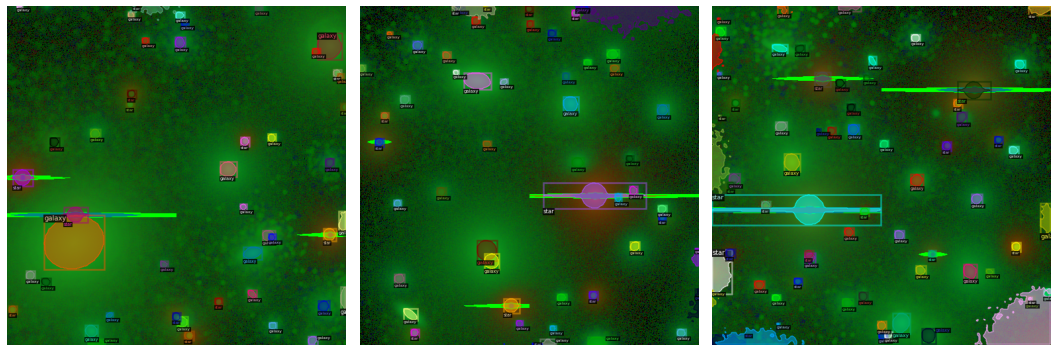

In [9]:
dataset_dicts = get_astro_dicts("/home/colinjb2/astro_rcnn/trainingset")

nsample = 3
fig, axs = plt.subplots(1, nsample, figsize=(5*nsample, 5))

for i, d in enumerate(random.sample(dataset_dicts, nsample)):
    img = read_image(d["file_name"], normalize="lupton")
    visualizer = Visualizer(img, metadata=astro_metadata, scale=1)
    out = visualizer.draw_dataset_dict(d)
    axs[i].imshow(out.get_image())
    axs[i].axis('off')
    fig.tight_layout()
    fig.show()

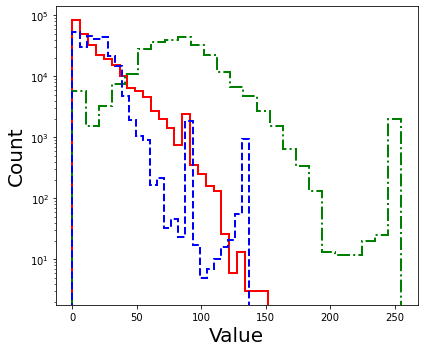

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
bins = 25
ax.hist(img[:,:,0].flatten(), histtype="step", bins=bins, log=True, color="r", lw=2, zorder=1);
ax.hist(img[:,:,1].flatten(), histtype="step", bins=bins, log=True, color="g", lw=2, linestyle='-.', zorder=2);
ax.hist(img[:,:,2].flatten(), histtype="step", bins=bins, log=True, color="b", lw=2, linestyle='dashed', zorder=3);
ax.set_xlabel('Value', fontsize=20)
ax.set_ylabel('Count', fontsize=20)
fig.tight_layout()

### Re-Train

In [6]:
from detectron2.engine import DefaultTrainer
import detectron2.data.transforms as T
from detectron2.data import detection_utils as utils
import copy
import torch

# Custom mapper
def mapper(dataset_dict):

    dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below

    image = read_image(dataset_dict["file_name"])

    # Data Augmentation
    auginput = T.AugInput(image)
    transform = T.Resize((512, 512))(auginput) # remove this?
    image = torch.from_numpy(auginput.image.transpose(2, 0, 1))
    annos = [
        utils.transform_instance_annotations(annotation, [transform], image.shape[1:])
        for annotation in dataset_dict.pop("annotations")
    ]
    return {
       # create the format that the model expects
        "image": image,
        "height": 512,
        "width": 512,
        "image_id": dataset_dict["image_id"],
        "instances": utils.annotations_to_instances(annos, image.shape[1:])
    }

class Trainer(DefaultTrainer):

    @classmethod
    def build_train_loader(cls, cfg):        
        # Override DefaultTrainer with custom dataloader
        return build_detection_train_loader(cfg, mapper=mapper)
    

In [7]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("astro_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = Trainer(cfg) 

[02/12 13:53:25 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [8]:
trainer.resume_or_load(resume=False)
trainer.train()

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (3, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (2, 256, 1, 1) in

[02/12 13:53:30 d2.engine.train_loop]: Starting training from iteration 0


/home/colinjb2/.conda/envs/opence-v1.1.1-colinjb2/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/home/colinjb2/.conda/envs/opence-v1.1.1-colinjb2/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/home/colinjb2/.conda/envs/opence-v1.1.1-colinjb2/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/home/colinjb2/.conda/envs/opence-v1.1.1-colinjb2/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/home/colinjb2/.conda/envs/opence-v1.1.1-colinjb2/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/home/colinjb2/.conda/envs/opence-v1.1.1-colinjb2/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/home/colinjb2/.conda/envs/opence-

[02/12 13:53:35 d2.utils.events]:  eta: 0:00:43  iter: 19  total_loss: 6.956  loss_cls: 1.033  loss_box_reg: 0.5656  loss_mask: 0.6912  loss_rpn_cls: 3.987  loss_rpn_loc: 0.6371  time: 0.1555  data_time: 0.0404  lr: 4.9953e-06  max_mem: 1181M
[02/12 13:53:38 d2.utils.events]:  eta: 0:00:41  iter: 39  total_loss: 4.439  loss_cls: 0.9873  loss_box_reg: 0.6865  loss_mask: 0.6889  loss_rpn_cls: 1.523  loss_rpn_loc: 0.5259  time: 0.1598  data_time: 0.0380  lr: 9.9902e-06  max_mem: 1181M
[02/12 13:53:41 d2.utils.events]:  eta: 0:00:38  iter: 59  total_loss: 3.289  loss_cls: 0.9035  loss_box_reg: 0.6544  loss_mask: 0.6829  loss_rpn_cls: 0.5961  loss_rpn_loc: 0.4322  time: 0.1593  data_time: 0.0343  lr: 1.4985e-05  max_mem: 1181M
[02/12 13:53:44 d2.utils.events]:  eta: 0:00:35  iter: 79  total_loss: 3.047  loss_cls: 0.7995  loss_box_reg: 0.6683  loss_mask: 0.6721  loss_rpn_cls: 0.4655  loss_rpn_loc: 0.4283  time: 0.1592  data_time: 0.0325  lr: 1.998e-05  max_mem: 1181M
[02/12 13:53:48 d2.utils

In [1]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output --host localhost

Reusing TensorBoard on port 6007 (pid 124445), started 0:02:01 ago. (Use '!kill 124445' to kill it.)

### Inference

In [10]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

/home/colinjb2/.conda/envs/opence-v1.1.1-colinjb2/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/home/colinjb2/.conda/envs/opence-v1.1.1-colinjb2/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/home/colinjb2/.conda/envs/opence-v1.1.1-colinjb2/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


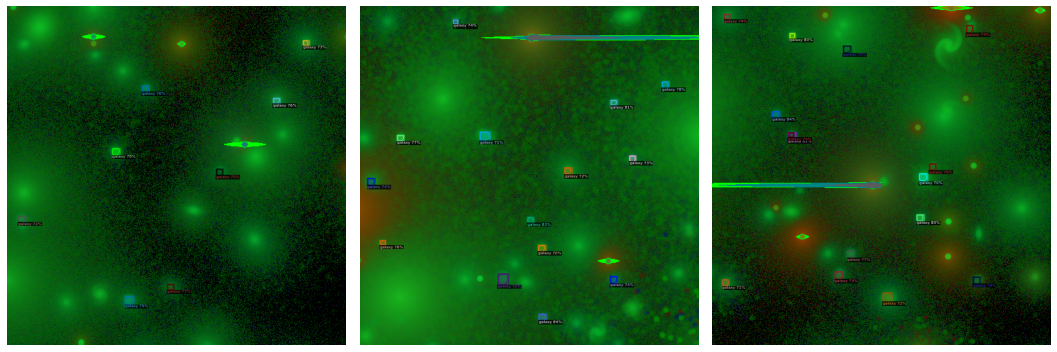

In [11]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_astro_dicts("/home/colinjb2/astro_rcnn/trainingset") # Replace this with the validation dataset

nsample = 3
fig, axs = plt.subplots(1, nsample, figsize=(5*nsample, 5))

for i, d in enumerate(random.sample(dataset_dicts, nsample)):
    im = read_image(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im,
                   metadata=astro_metadata, 
                   scale=1, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    axs[i].imshow(out.get_image())
    axs[i].axis('off')
    fig.tight_layout()
    fig.show()

### Evaluate

In [12]:
#See https://detectron2.readthedocs.io/en/latest/_modules/detectron2/evaluation/coco_evaluation.html#COCOEvaluator
#Colin TODO: Implement deblending metric evaluator

# Need more "intuitive deblending metric"
# IoU vs. source density at fixed threshold
# ellipticity vs. source density

class Counter(DatasetEvaluator):
  def reset(self):
    self.count = 0
  def process(self, inputs, outputs):
    for output in outputs:
      self.count += len(output["instances"])
  def evaluate(self):
    # save self.count somewhere, or print it, or return it.
    return {"count": self.count}

OrderedDict()

In [13]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("astro_val", cfg, False, output_dir="./output/") # Should be astro_val
# Need to override this too I guess
val_loader = build_detection_test_loader(cfg, "astro_val", mapper=mapper) # Should be astro_val
print(inference_on_dataset(trainer.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

WARNING [02/12 13:54:34 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[02/12 13:54:34 d2.evaluation.coco_evaluation]: 'astro_val' is not registered by `register_coco_instances`. Therefore trying to convert it to COCO format ...
WARNING [02/12 13:54:34 d2.data.datasets.coco]: Using previously cached COCO format annotations at './output/astro_val_coco_format.json'. You need to clear the cache file if your dataset has been modified.
[02/12 13:54:36 d2.data.common]: Serializing 10 elements to byte tensors and concatenating them all ...
[02/12 13:54:36 d2.data.common]: Serialized dataset takes 0.09 MiB
[02/12 13:54:36 d2.evaluation.evaluator]: Start inference on 10 images


/home/colinjb2/.conda/envs/opence-v1.1.1-colinjb2/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/home/colinjb2/.conda/envs/opence-v1.1.1-colinjb2/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/home/colinjb2/.conda/envs/opence-v1.1.1-colinjb2/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/home/colinjb2/.conda/envs/opence-v1.1.1-colinjb2/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/home/colinjb2/.conda/envs/opence-v1.1.1-colinjb2/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/home/colinjb2/.conda/envs/opence-v1.1.1-colinjb2/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/home/colinjb2/.conda/envs/opence-

[02/12 13:54:38 d2.evaluation.evaluator]: Total inference time: 0:00:00.536653 (0.107331 s / img per device, on 1 devices)
[02/12 13:54:38 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:00 (0.042995 s / img per device, on 1 devices)
[02/12 13:54:38 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[02/12 13:54:38 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[02/12 13:54:38 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[02/12 13:54:38 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[02/12 13:54:38 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.02 seconds.
[02/12 13:54:38 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[02/12 13:54:38 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.00 seconds.
 Average Precision  (AP) @

In [ ]:
#Yufeng TODO: Parse this output and create precision-recall matplotlib plots at each IOU like in Burke (2019) Figures 8-10